In [38]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import os,cv2,keras

In [60]:
X_new = np.load('/kaggle/input/images-npf/X_new.npy')
Y_new = np.load('/kaggle/input/images-npf/Y_new.npy')

In [62]:
from sklearn.utils import shuffle
X_new,Y_new = shuffle(X_new,Y_new,random_state = 20)
X_new = X_new[:4000]
Y_new = Y_new[:4000]

In [63]:
from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

In [64]:
# weights of VGG16 architecture is being used
vggmodel = VGG16(weights='imagenet', include_top=True)  # include_top adds a fully connected layer at the top
vggmodel.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [65]:
for layers in (vggmodel.layers)[:15]: # as there are 16 layers
  print(layers)
  layers.trainable = False  # the layers don't get trained


In [66]:
X = vggmodel.layers[-2].output

In [67]:
# predictions = Dense(1,activation='sigmoid')(X)
predictions = Dense(2,activation='softmax')(X) # removing the last layer and adding an output layer of 2 nodes

In [68]:
model_final = Model(vggmodel.input,predictions)

In [69]:
from keras.optimizers import Adam
opt = Adam(lr=0.0005)

/opt/conda/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [70]:
# it helps to create the complete model
# model_final.compile(loss=keras.losses.BinaryCrossentropy(from_logits= True), optimizer = opt,metrics = ['accuracy'])
model_final.compile(loss=keras.losses.categorical_crossentropy, optimizer = opt,metrics = ['accuracy'])

In [71]:
model_final.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [72]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [73]:
class MyLabelBinarizer(LabelBinarizer):
  def transform(self,y):
    Y = super().transform(y)
    if self.y_type_ == 'binary':
      return np.hstack((Y,1-Y))
    else:
      return Y
  
  def inverse_transform(self,Y,threshold=None):
    if self.y_type_ == 'binary':
      return super().inverse_transform(Y[:,0],threshold)
    else:
      return super().inverse_transform(Y,threshold)

In [75]:
lenc = MyLabelBinarizer()
Y = lenc.fit_transform(Y_new)

In [17]:
from sklearn.utils import shuffle
X_final_train,Y_final_train = shuffle(X_new,Y,random_state = 20)

In [78]:
X_train, X_test, Y_train, Y_test = train_test_split(X_final_train,Y_final_train,test_size=0.1,shuffle=True,stratify = Y_final_train)

In [89]:
batch_size = 512
nb_epoch = 10
steps_per_epoch = np.ceil(4500/batch_size)
validation_steps = np.ceil(500/batch_size)

In [93]:
# # Doing Data Augmentation

trdata = ImageDataGenerator(horizontal_flip = True, vertical_flip = True, rotation_range = 90)
train_data = trdata.flow(x = X_train, y = Y_train)
tsdata = ImageDataGenerator(horizontal_flip = True, vertical_flip = True, rotation_range = 90)
test_data = tsdata.flow(x = X_test, y = Y_test)

In [95]:
def load_data(X_train,Y_train,idx,batch_size):
    st = idx*batch_size
    nrows = st+batch_size
    x = X_train[st:nrows]
    y = Y_train[st:nrows]
    return x,y

In [96]:
def batch_generator(X_train,Y_train,batch_size,steps):
    idx=1
    while True:
        yield load_data(X_train,Y_train,idx-1,batch_size)
        if idx<steps:
            idx += 1
        else:
            idx = 1

In [97]:
train_batch = batch_generator(X_train,Y_train,512,steps_per_epoch)
valid_batch = batch_generator(X_test,Y_test,512,validation_steps)

In [98]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [99]:
# For Creating Check Points
checkpoint = ModelCheckpoint("rcnn_vgg16_1_Final1.h5",monitor = 'val_loss',verbose=1, save_best_only = True, save_Weights_only = False, mode = 'auto', period = 1)

In [100]:
# For Early Stopping
early = EarlyStopping(monitor = 'val_loss',min_delta = 0,patience = 2, verbose = 1, mode='auto')
# monitor is the metrics on which early stopping is dependent
# patience is the number of more epoches the model should continue to train when it detects that the
# "val_loss" is not decreasing further or increasing. After the patience no of epoch from that point
# where it detects, the execution of the model stops
# mode is the parameter which checks "min" or "max" of the metrics. In loss, it checks till the metrics reaches minimum

In [101]:
 # Training the model with fit_generator
hist = model_final.fit_generator(train_batch,epochs = nb_epoch,steps_per_epoch = steps_per_epoch,verbose=1,validation_data = valid_batch,validation_steps = validation_steps)
# hist = model_final.fit(x=X_train,y=Y_train, steps_per_epoch = none, epochs = 10, validation_data = (X_test,Y_test), validation_steps = 2, callbacks = [checkpoint,early])

Epoch 1/10


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


9/9 [==============================] - 1667s 186s/step - loss: 15.8898 - accuracy: 0.5249 - val_loss: 0.6277 - val_accuracy: 0.7280
Epoch 2/10
9/9 [==============================] - 1635s 184s/step - loss: 0.8219 - accuracy: 0.5964 - val_loss: 0.5259 - val_accuracy: 0.7520
Epoch 3/10
9/9 [==============================] - 1665s 186s/step - loss: 0.5845 - accuracy: 0.6918 - val_loss: 0.5047 - val_accuracy: 0.7620
Epoch 4/10
9/9 [==============================] - 1675s 187s/step - loss: 0.6225 - accuracy: 0.6587 - val_loss: 0.5289 - val_accuracy: 0.7520
Epoch 5/10
9/9 [==============================] - 1696s 190s/step - loss: 0.5357 - accuracy: 0.7309 - val_loss: 0.4856 - val_accuracy: 0.7580
Epoch 6/10
9/9 [==============================] - 1664s 186s/step - loss: 0.5103 - accuracy: 0.7467 - val_loss: 0.4655 - val_accuracy: 0.7740
Epoch 7/10
9/9 [==============================] - 1684s 189s/step - loss: 0.5085 - accuracy: 0.7518 - val_loss: 0.5152 - val_accuracy: 0.7320
Epoch 8/10
9/9 [

In [102]:
model_final.save("rcnn_vgg16_1_Final1.h5")

In [117]:
model_final.save_weights("rcnn_vgg16_Final_Weights.h5")

In [119]:
from IPython.display import FileLink
FileLink(r'rcnn_vgg16_Final_Weights.h5')

/kaggle/working/rcnn_vgg16_Final_Weights.h5

In [104]:
from IPython.display import FileLink
FileLink(r'rcnn_vgg16_1_Final1.h5')

/kaggle/working/rcnn_vgg16_1_Final1.h5

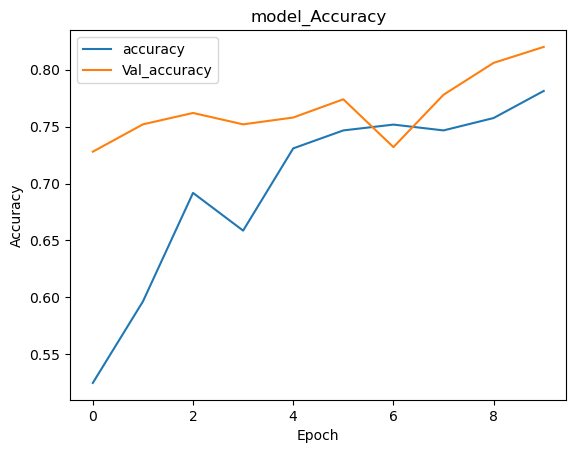

In [106]:
# For visualizing different loss
import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title("model_Accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['accuracy','Val_accuracy'])
plt.show()